In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.cluster import KMeans
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

pd.set_option('display.max_columns', None)

In [73]:
# Loading the dataset
df = pd.read_csv("../data/raw/train(1).csv")
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,3,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,4,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,3,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,3,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,3,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16204,5272200045,20141113T000000,378000,3,1.50,1000,6914,1.0,0,0,3,7,1000,0,1947,0,98125,47.7144,-122.319,1000,6947
16205,9578500790,20141111T000000,399950,3,2.50,3087,5002,2.0,0,0,3,8,3087,0,2014,0,98023,47.2974,-122.349,2927,5183
16206,7202350480,20140930T000000,575000,3,2.50,2120,4780,2.0,0,0,3,7,2120,0,2004,0,98053,47.6810,-122.032,1690,2650
16207,1723049033,20140620T000000,245000,1,0.75,380,15000,1.0,0,0,3,5,380,0,1963,0,98168,47.4810,-122.323,1170,15000


In [74]:
# The features
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [75]:
df.shape

(16209, 21)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   price          16209 non-null  int64  
 3   bedrooms       16209 non-null  int64  
 4   bathrooms      16209 non-null  float64
 5   sqft_living    16209 non-null  int64  
 6   sqft_lot       16209 non-null  int64  
 7   floors         16209 non-null  float64
 8   waterfront     16209 non-null  int64  
 9   view           16209 non-null  int64  
 10  condition      16209 non-null  int64  
 11  grade          16209 non-null  int64  
 12  sqft_above     16209 non-null  int64  
 13  sqft_basement  16209 non-null  int64  
 14  yr_built       16209 non-null  int64  
 15  yr_renovated   16209 non-null  int64  
 16  zipcode        16209 non-null  int64  
 17  lat            16209 non-null  float64
 18  long  

No NaN values, mostly integer and floating values.

In [77]:
df.id.duplicated().sum()

np.int64(99)

Since there are duplicate prices for same houses, that means a house might've been sold more than once. Hence, we'll keep the prices that are the most recent ones.

In [78]:
# Sort by date so the newest sales are at the top
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date', ascending=False)


df = df.drop_duplicates(subset='id', keep='first')

In [79]:
df.describe()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.611000e+04,16110,1.611000e+04,16110.000000,16110.000000,16110.000000,1.611000e+04,16110.000000,16110.000000,16110.000000,16110.000000,16110.000000,16110.000000,16110.000000,16110.000000,16110.000000,16110.000000,16110.000000,16110.000000,16110.000000,16110.000000
mean,4.575462e+09,2014-10-29 10:11:55.977653504,5.385188e+05,3.368094,2.115115,2075.411421,1.487569e+04,1.500279,0.007014,0.234823,3.408628,7.656797,1786.872998,288.538423,1971.230664,83.001490,98077.902048,47.560692,-122.213899,1984.516636,12739.404283
min,1.000102e+06,2014-05-02 00:00:00,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.159300,-122.519000,399.000000,651.000000
25%,2.123049e+09,2014-07-22 00:00:00,3.230000e+05,3.000000,1.750000,1430.000000,5.001000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1952.000000,0.000000,98033.000000,47.472300,-122.328000,1480.000000,5092.000000
50%,3.904940e+09,2014-10-16 00:00:00,4.500000e+05,3.000000,2.250000,1910.000000,7.589500e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.572600,-122.230000,1840.000000,7615.000000
75%,7.304301e+09,2015-02-17 00:00:00,6.400000e+05,4.000000,2.500000,2550.000000,1.063850e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2200.000000,560.000000,1997.000000,0.000000,98117.000000,47.678200,-122.125000,2360.000000,10058.750000
max,9.900000e+09,2015-05-24 00:00:00,7.700000e+06,33.000000,8.000000,12050.000000,1.164794e+06,3.500000,1.000000,4.000000,5.000000,13.000000,8860.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000
std,2.875260e+09,NaN,3.602537e+05,0.932351,0.765132,907.548014,3.887553e+04,0.543230,0.083460,0.763427,0.651000,1.170048,822.425006,438.865284,29.384455,398.473237,53.339003,0.138435,0.140137,682.117246,26964.164036


Bathrooms and Bedrooms attribute seem to have outliers, so we might have to treat that later

In [80]:
df.bathrooms.unique()

array([1.75, 2.  , 3.  , 2.5 , 2.25, 1.  , 1.5 , 2.75, 3.5 , 0.75, 4.25,
       5.  , 3.25, 3.75, 4.  , 4.5 , 6.  , 4.75, 5.25, 1.25, 0.  , 6.5 ,
       5.75, 0.5 , 5.5 , 8.  , 7.75, 6.25, 6.75])

Apparantely these decimal values indicate - <br> **0.5:** A half-bath (Toilet + Sink, no shower/tub) <br> **0.75:** A three-quarter bath (Toilet + Sink + Shower, no tub) <br> **1.0:** A full bath (Toilet + Sink + Shower + Tub) <br> **2.25/2.5:** A combination of full and partial bathrooms <br><br> Hence we need not round them up

Now I'll generate some plots that might help figure out pattern between the features

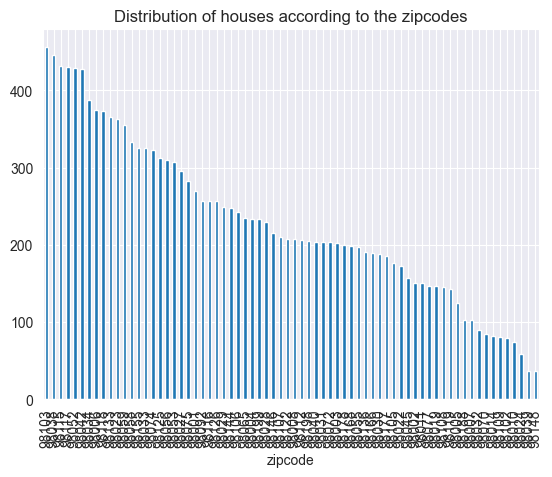

In [81]:
df['zipcode'].value_counts().plot(kind='bar')
plt.title('Distribution of houses according to the zipcodes')
plt.show()

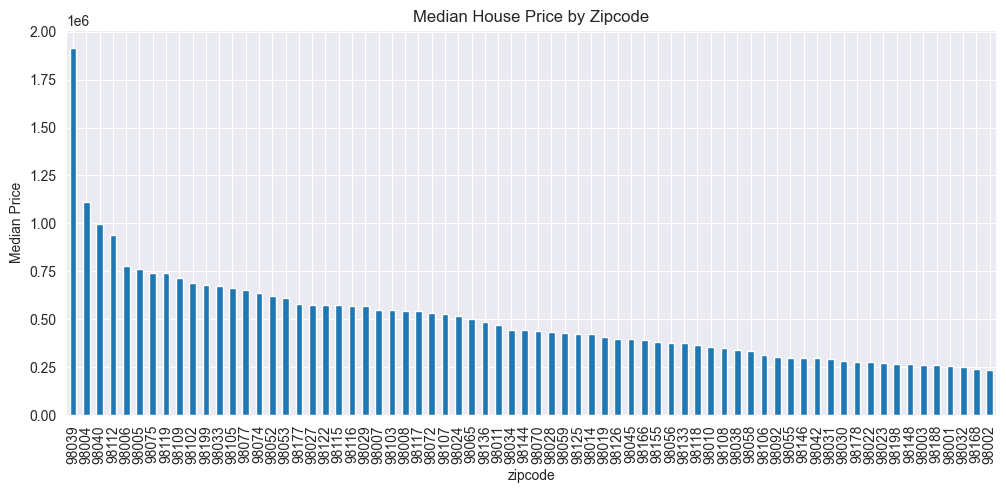

In [82]:
zipcode_price = (
    df.groupby('zipcode')['price']
    .median()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12, 5))
zipcode_price.plot(kind='bar')
plt.ylabel("Median Price")
plt.title("Median House Price by Zipcode")
plt.xticks(rotation=90)
plt.show()

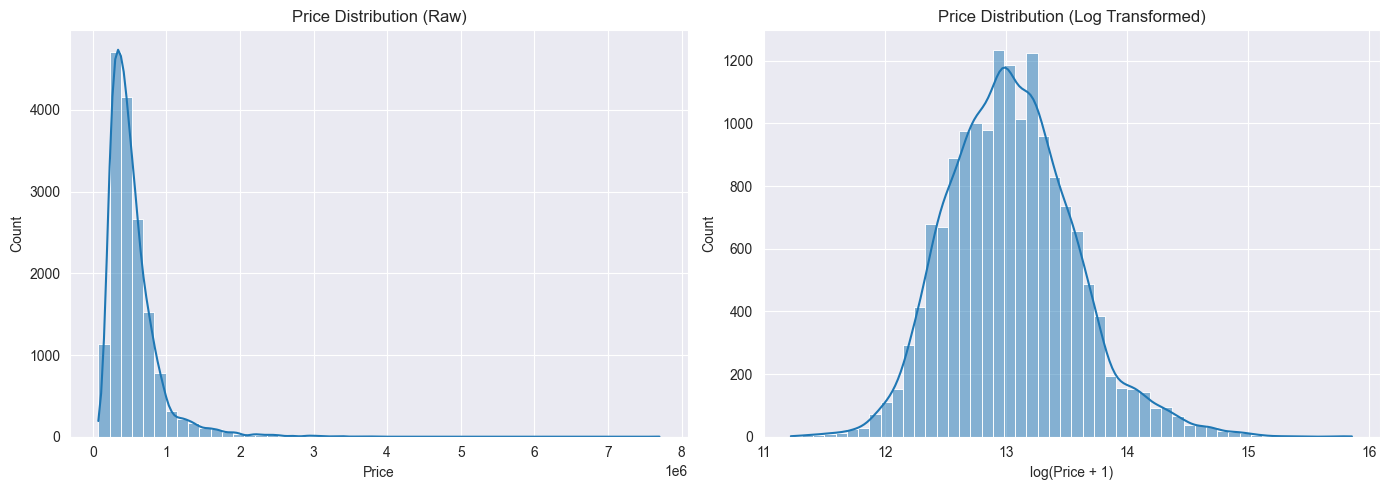

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['price'], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Price Distribution (Raw)")
axes[0].set_xlabel("Price")

sns.histplot(np.log1p(df['price']), bins=50, kde=True, ax=axes[1])
axes[1].set_title("Price Distribution (Log Transformed)")
axes[1].set_xlabel("log(Price + 1)")

plt.tight_layout()
plt.show()


# The raw price distribution is heavily skewed, log transformation stabilizes variance and improves regression performance

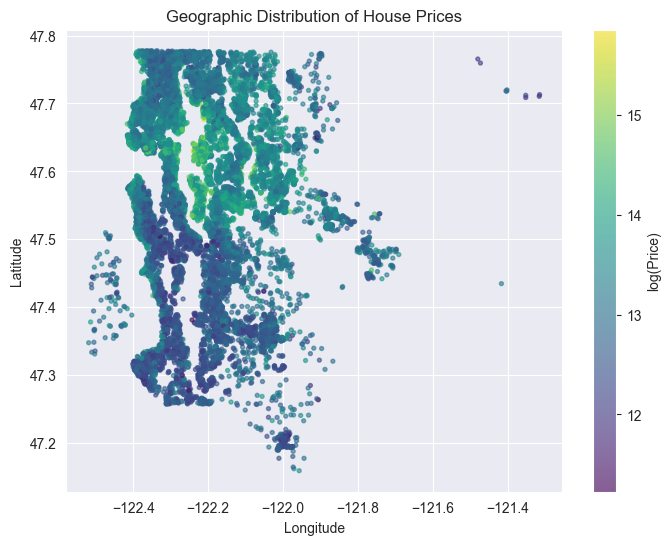

In [84]:
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    df['long'],
    df['lat'],
    c=np.log1p(df['price']),
    cmap='viridis',
    s=8,
    alpha=0.6
)
plt.colorbar(sc, label="log(Price)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of House Prices")
plt.show()


# Pricing of the houses is majorly affected by the location

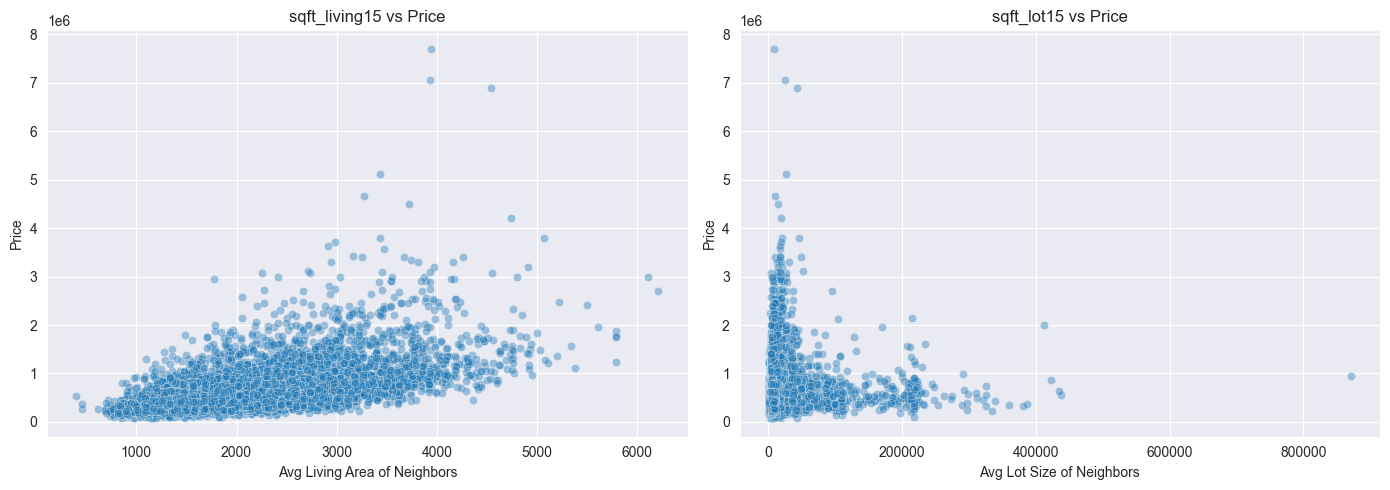

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(
    x=df['sqft_living15'],
    y=df['price'],
    alpha=0.4,
    ax=axes[0]
)
axes[0].set_title("sqft_living15 vs Price")
axes[0].set_xlabel("Avg Living Area of Neighbors")
axes[0].set_ylabel("Price")

sns.scatterplot(
    x=df['sqft_lot15'],
    y=df['price'],
    alpha=0.4,
    ax=axes[1]
)
axes[1].set_title("sqft_lot15 vs Price")
axes[1].set_xlabel("Avg Lot Size of Neighbors")
axes[1].set_ylabel("Price")

plt.tight_layout()
plt.show()


# Properties are valued relative to surrounding neighborhood scale

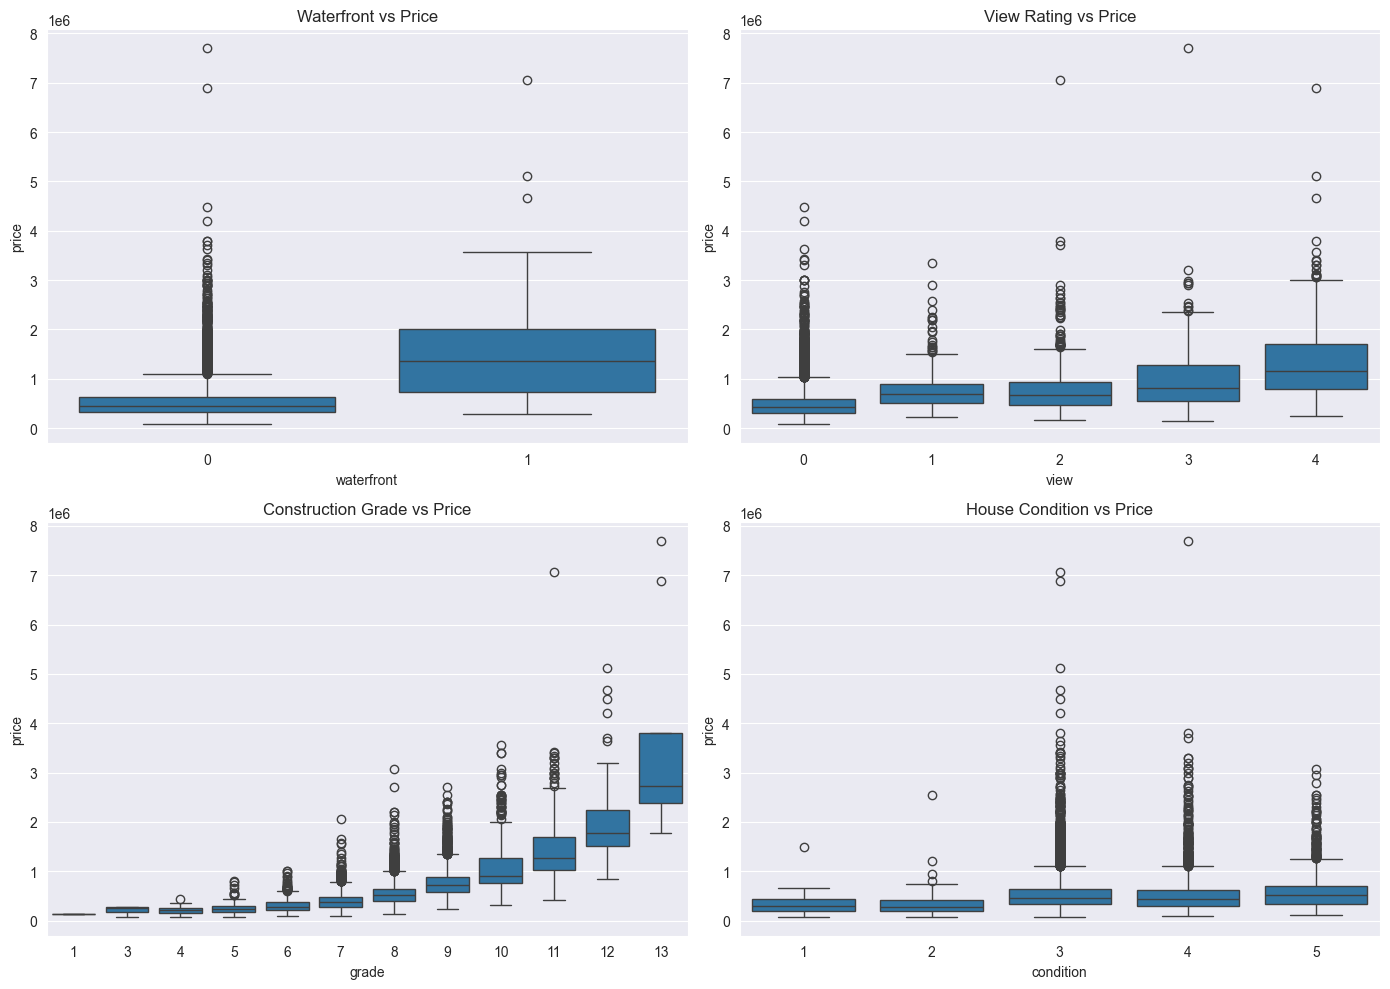

In [86]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.boxplot(x='waterfront', y='price', data=df, ax=axes[0, 0])
axes[0, 0].set_title("Waterfront vs Price")

sns.boxplot(x='view', y='price', data=df, ax=axes[0, 1])
axes[0, 1].set_title("View Rating vs Price")

sns.boxplot(x='grade', y='price', data=df, ax=axes[1, 0])
axes[1, 0].set_title("Construction Grade vs Price")

sns.boxplot(x='condition', y='price', data=df, ax=axes[1, 1])
axes[1, 1].set_title("House Condition vs Price")

plt.tight_layout()
plt.show()


# Shows the price distrbution based on categorical features

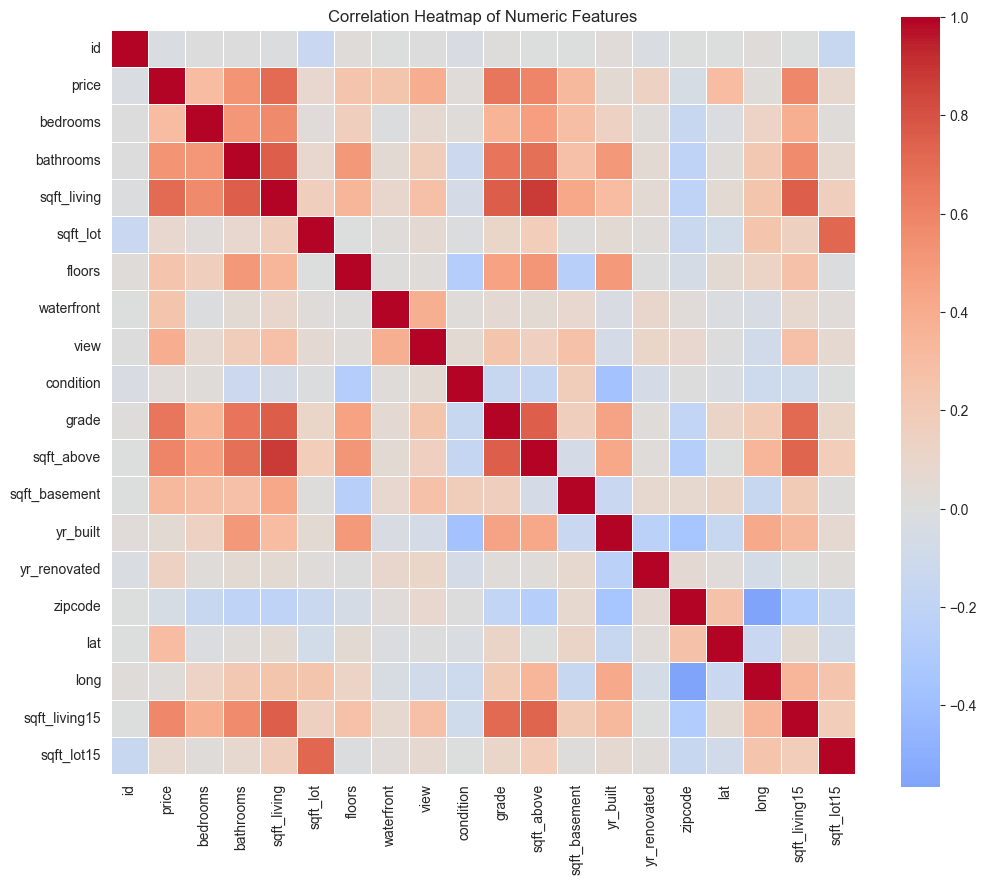

In [87]:
numeric_cols = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 10))
sns.heatmap(
    numeric_cols.corr(),
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5
)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

In [88]:
numeric_df = df.select_dtypes(exclude=['object']).copy()
numeric_df.corr()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,0.006298,-0.021961,0.005092,0.006555,-0.010500,-0.139975,0.018494,-0.008812,0.004572,-0.029058,0.009185,-0.006820,-0.008933,0.029637,-0.021795,-0.007842,-0.008114,0.019025,-0.003239,-0.144918
date,0.006298,1.000000,0.003080,-0.015461,-0.027739,-0.026923,0.008331,-0.023898,-0.002101,-0.003074,-0.052284,-0.032586,-0.021256,-0.015842,-0.001832,-0.028061,0.002207,-0.028673,-0.004387,-0.023954,0.002893
price,-0.021961,0.003080,1.000000,0.305539,0.524873,0.700373,0.087222,0.249728,0.245768,0.390154,0.029074,0.663320,0.601561,0.321017,0.046063,0.133626,-0.052256,0.310190,0.023096,0.580502,0.075232
bedrooms,0.005092,-0.015461,0.305539,1.000000,0.514142,0.572199,0.031324,0.173166,-0.014036,0.067721,0.026166,0.352991,0.473298,0.296323,0.148782,0.020768,-0.155176,-0.016585,0.127485,0.384829,0.023965
bathrooms,0.006555,-0.027739,0.524873,0.514142,1.000000,0.751972,0.082352,0.503071,0.055646,0.176523,-0.129588,0.664529,0.682943,0.275212,0.503536,0.052824,-0.202818,0.024052,0.222355,0.563655,0.075310
sqft_living,-0.010500,-0.026923,0.700373,0.572199,0.751972,1.000000,0.171617,0.347688,0.088866,0.274040,-0.062629,0.760745,0.875831,0.426652,0.314367,0.056601,-0.203727,0.051055,0.243827,0.754848,0.171863
sqft_lot,-0.139975,0.008331,0.087222,0.031324,0.082352,0.171617,1.000000,-0.006397,0.027003,0.062260,-0.012609,0.112068,0.181622,0.014538,0.049174,0.017618,-0.135731,-0.082496,0.245540,0.154602,0.720363
floors,0.018494,-0.023898,0.249728,0.173166,0.503071,0.347688,-0.006397,1.000000,0.014334,0.022669,-0.272141,0.456837,0.517649,-0.251066,0.497559,0.006306,-0.057013,0.051651,0.125050,0.270637,-0.013967
waterfront,-0.008812,-0.002101,0.245768,-0.014036,0.055646,0.088866,0.027003,0.014334,1.000000,0.384323,0.019223,0.060888,0.057390,0.076223,-0.037464,0.090156,0.028016,-0.016506,-0.041954,0.071722,0.033170
view,0.004572,-0.003074,0.390154,0.067721,0.176523,0.274040,0.062260,0.022669,0.384323,1.000000,0.046985,0.241800,0.157307,0.271908,-0.060917,0.100692,0.087803,0.003594,-0.085777,0.276536,0.064972


In [89]:
inconsistent_data = df[df['sqft_living'] != (df['sqft_above'] + df['sqft_basement'])]
inconsistent_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


Hi correlation : sqft_above and sqft_living 0.875830 <br> Also since the sqft_above = sqft_living - sqft_basement, we'll just drop sqft_above. <br> This helps reduce the number of dimensions in the dataset

In [90]:
# K-means Clustering
# We do this to make the model understand spatial clusters regardless of political boundaries
# It forces the model to see a balanced mix of "environmental contexts" (trees, water, concrete) across both datasets (training and validation).

# Cluster the coordinates into 30 geographical zones
coords = df[['lat', 'long']]
kmeans = KMeans(n_clusters=30, random_state=42, n_init=10).fit(coords)
df['geo_cluster'] = kmeans.labels_

# Stratify based on these visual clusters
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['geo_cluster']
)

In [91]:
train_df.describe()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,geo_cluster
count,1.288800e+04,12888,1.288800e+04,12888.000000,12888.000000,12888.000000,1.288800e+04,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000,12888.000000
mean,4.563917e+09,2014-10-29 11:26:48.938547456,5.396060e+05,3.375466,2.115320,2077.971136,1.480104e+04,1.501241,0.006983,0.234094,3.407278,7.658442,1789.373138,288.597998,1971.210739,85.009156,98077.923572,47.560790,-122.213934,1985.581471,12779.356999,12.924348
min,1.000102e+06,2014-05-02 00:00:00,8.000000e+04,0.000000,0.000000,290.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.159300,-122.514000,399.000000,748.000000,0.000000
25%,2.112701e+09,2014-07-22 00:00:00,3.245000e+05,3.000000,1.500000,1430.000000,5.000000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1952.000000,0.000000,98033.000000,47.472475,-122.328000,1490.000000,5080.000000,6.000000
50%,3.904901e+09,2014-10-16 00:00:00,4.500000e+05,3.000000,2.250000,1910.000000,7.589500e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.573100,-122.230000,1840.000000,7600.000000,12.000000
75%,7.308675e+09,2015-02-17 00:00:00,6.410000e+05,4.000000,2.500000,2550.000000,1.058400e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2200.000000,560.000000,1997.000000,0.000000,98117.000000,47.678300,-122.125000,2360.000000,10050.000000,20.000000
max,9.900000e+09,2015-05-24 00:00:00,7.700000e+06,33.000000,8.000000,12050.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,13.000000,8860.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.316000,6210.000000,438213.000000,29.000000
std,2.878336e+09,NaN,3.642308e+05,0.941203,0.764518,910.460248,3.779227e+04,0.542232,0.083277,0.764439,0.648233,1.167658,824.919183,438.410196,29.415664,403.041973,53.287274,0.138448,0.140107,681.394115,26602.399919,8.552692


In [92]:
# Numerical columns to draw pair-plots later
numeric_ = train_df.select_dtypes(exclude=['object']).copy()
numeric_.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'geo_cluster'],
      dtype='object')

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/seaborn/axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


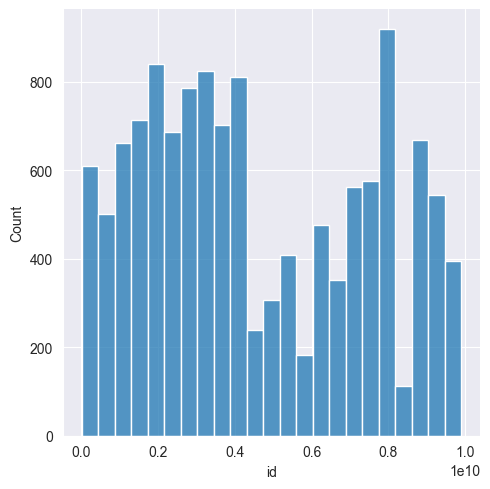

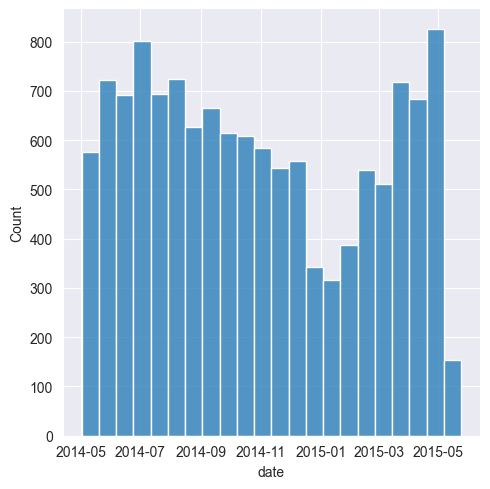

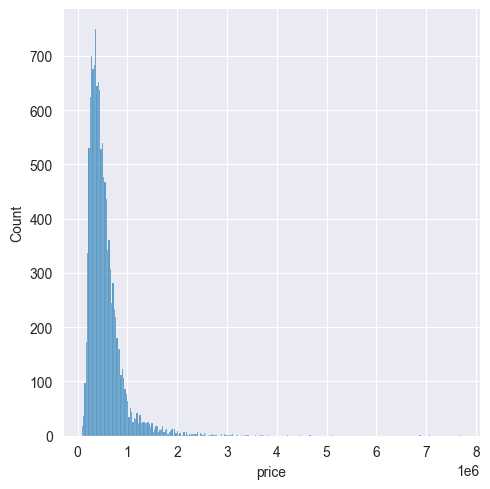

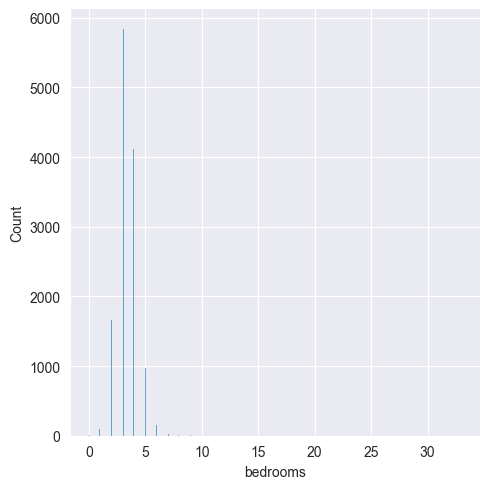

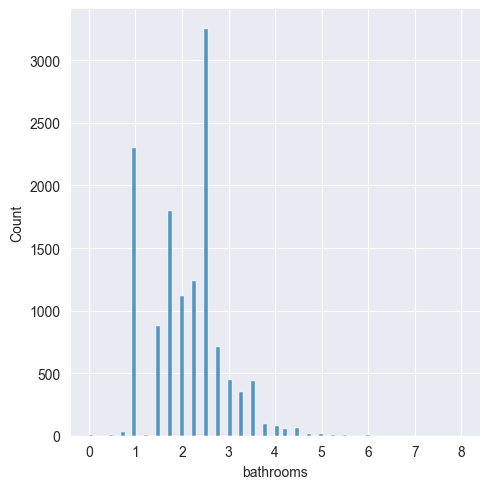

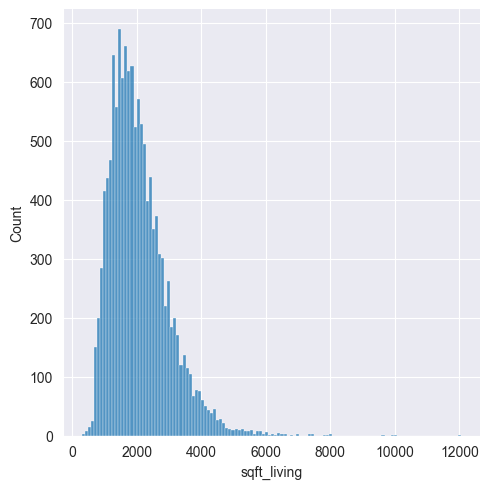

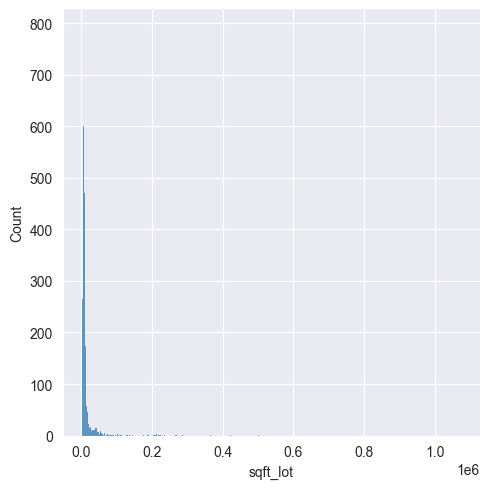

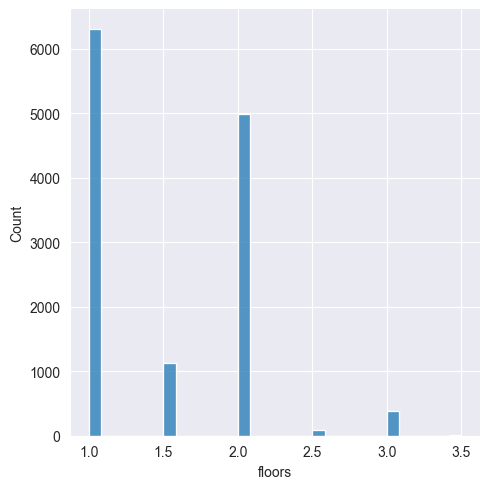

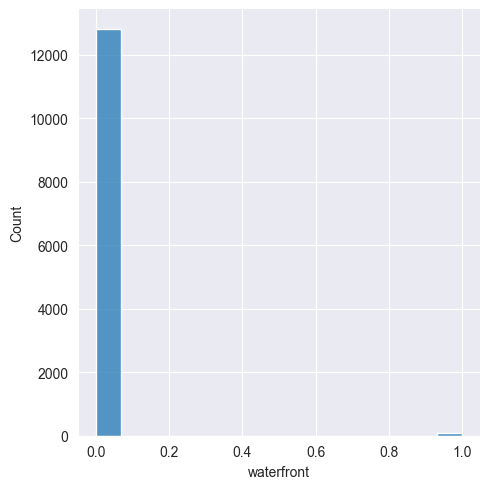

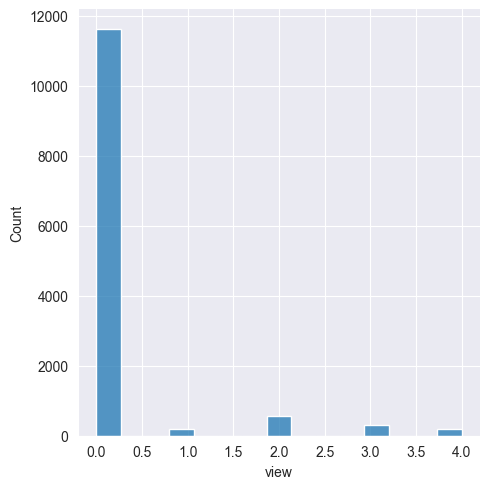

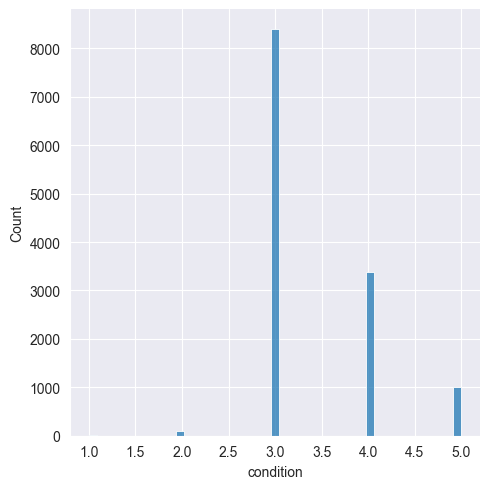

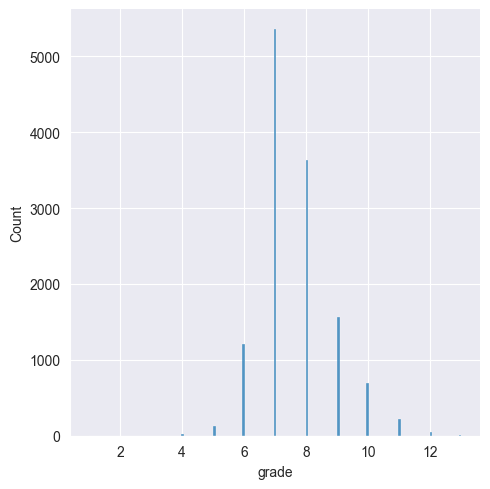

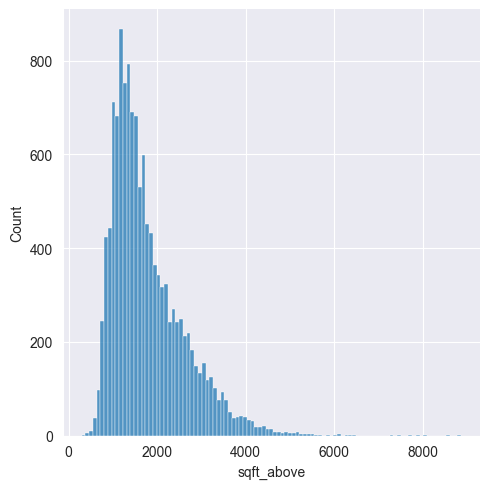

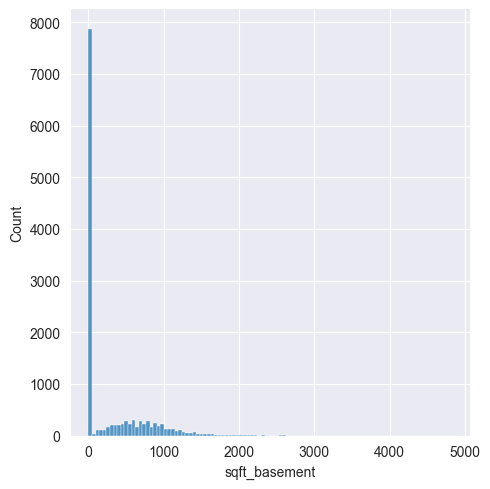

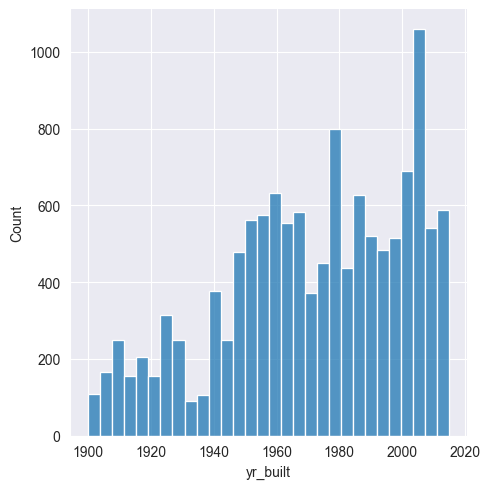

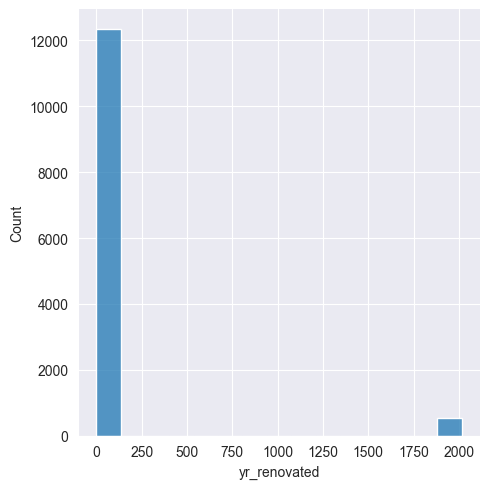

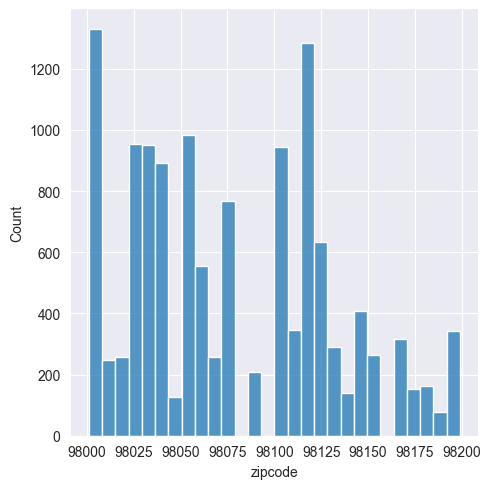

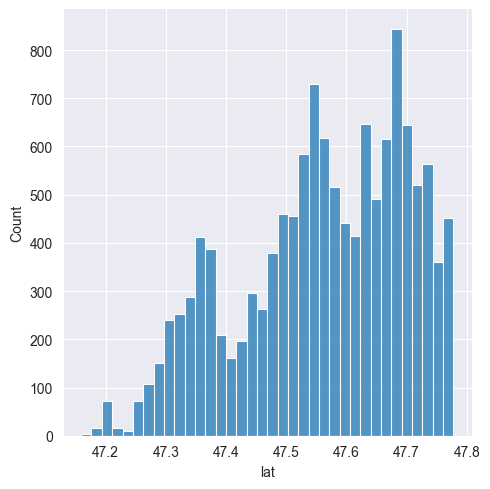

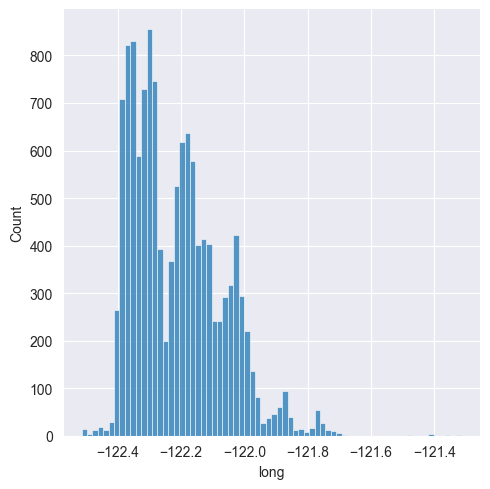

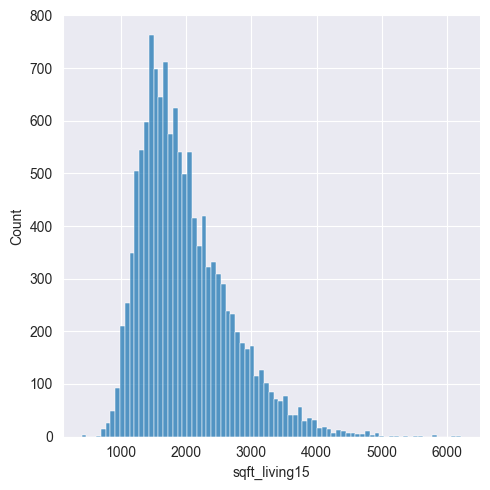

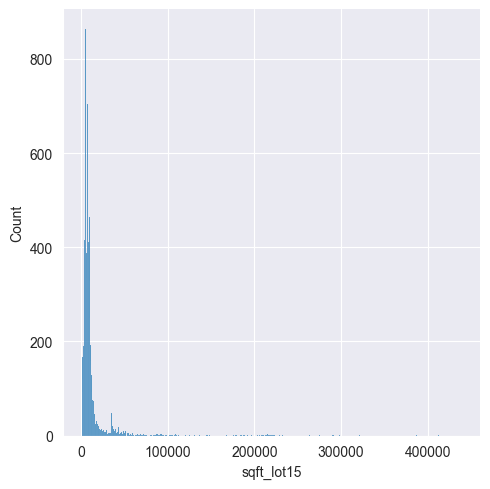

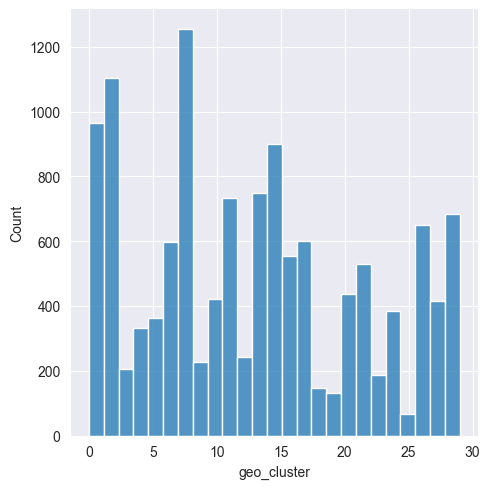

<Figure size 600x500 with 0 Axes>

In [93]:
for i in range(len(numeric_.columns)):
    fig.add_subplot(9,4,i+1)
    sns.displot(numeric_.iloc[:,i].dropna())
    plt.xlabel(numeric_.columns[i])

fig = plt.figure(figsize=(6, 5))
plt.tight_layout()
plt.show()

In [94]:
train_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,geo_cluster
15237,4322300010,2014-06-06,294700,3,2.00,1970,9600,1.0,0,0,4,7,1300,670,1967,0,98003,47.2824,-122.301,1710,7703,7
402,8835350230,2014-08-25,530000,3,2.50,2480,7480,2.0,0,0,3,9,2480,0,1992,0,98072,47.7710,-122.166,2480,7480,17
14109,4302200625,2014-09-24,335000,3,1.75,1790,5120,1.0,0,0,4,6,940,850,1949,0,98106,47.5277,-122.355,1160,5120,8
1944,2624049185,2014-09-09,405000,3,1.75,1760,5355,1.0,0,0,3,7,1160,600,1956,0,98118,47.5368,-122.267,1790,6225,14
15320,1036000280,2015-02-17,675000,4,1.75,2440,7475,1.0,0,0,4,9,2040,400,1969,0,98052,47.6339,-122.096,2040,8480,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15016,7129302235,2015-01-22,325000,3,1.75,2080,6554,1.0,0,0,3,7,1040,1040,1950,0,98118,47.5135,-122.257,1230,5650,14
5951,1329300300,2014-10-01,335000,4,2.50,2154,6050,2.0,0,0,3,8,2154,0,2012,0,98030,47.3513,-122.174,2305,5769,16
10104,8562720230,2014-11-07,980000,4,3.25,3720,7150,2.0,0,2,3,11,3720,0,2007,0,98027,47.5359,-122.069,4040,7442,3
3897,5493100366,2014-06-25,1700000,5,3.50,5850,22885,2.0,0,2,4,11,4670,1180,1978,0,98004,47.6060,-122.211,3240,19020,20


In [95]:
y_train = train_df['price']
X_train = train_df.drop('price', axis=1)
y_val = val_df['price']
X_val = val_df.drop('price', axis=1)

So now I'll apply a few transformations to my dataframe - <br>
1. Apply log transform then scale for skewed sqft data
2. Standard scaling for regular numeric counts
3. One-Hot Encoding for categorical/spatial data
4. Convert date to useful numeric features
5. Limiting the upper value of 'bedrooms' and 'bathrooms'

In [96]:
log_features = ['sqft_living', 'sqft_lot', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
categorical_features = ['waterfront', 'view', 'condition', 'grade', 'geo_cluster']
numeric_features = ['bedrooms', 'bathrooms', 'floors', 'yr_built', 'yr_renovated']


def log_transform(x):
    return np.log1p(x)

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        # log transform then scale
        ('log_scale', Pipeline([
            ('log', FunctionTransformer(log_transform)),
            ('scaler', StandardScaler())
        ]), log_features),

        # Standard scaling
        ('numeric', StandardScaler(), numeric_features),

        # One-Hot Encoding
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop' # Drop columns that aren't involved
)

# Processing the target attribute
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

# Converting date attribute
X_train['date'] = pd.to_datetime(X_train['date'])
X_train['sale_year'] = X_train['date'].dt.year
X_train['sale_month'] = X_train['date'].dt.month
X_val['date'] = pd.to_datetime(X_val['date'])
X_val['sale_year'] = X_val['date'].dt.year
X_val['sale_month'] = X_val['date'].dt.month

# Limiting 'bedrooms'
X_train['bedrooms'] = X_train['bedrooms'].clip(upper=10)
X_val['bedrooms'] = X_val['bedrooms'].clip(upper=10)

# Limiting 'bedrooms'
X_train ['bathrooms'] = X_train['bathrooms'].clip(upper=6)
X_val['bathrooms'] = X_val['bathrooms'].clip(upper=6)

# Store IDs for image mapping (or some other use later)
train_ids = X_train['id'].values
val_ids = X_val['id'].values

# Drop metadata that shouldn't be in the X_train and X_val matrix
cols_to_drop = ['id', 'date', 'sqft_above']
X_train = X_train.drop(columns=cols_to_drop)
X_val = X_val.drop(columns=cols_to_drop)

# Fit on Train and Transform both
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)

print(f"Preprocessed shape: {X_train_transformed.shape}")

Preprocessed shape: (12888, 64)


In [97]:
np.save('../data/processed/X_train.npy', X_train_transformed)
np.save('../data/processed/y_train.npy', y_train_log.values)
np.save('../data/processed/train_ids.npy', train_ids)

np.save('../data/processed/X_val.npy', X_val_transformed)
np.save('../data/processed/y_val.npy', y_val_log.values)
np.save('../data/processed/val_ids.npy', val_ids)

In [98]:
data_path = "../data/processed/"

X_train = np.load(f'{data_path}X_train.npy', allow_pickle=True)
y_train = np.load(f'{data_path}y_train.npy', allow_pickle=True)
train_ids = np.load(f'{data_path}train_ids.npy', allow_pickle=True)
X_val = np.load(f'{data_path}X_val.npy', allow_pickle=True)
y_val = np.load(f'{data_path}y_val.npy', allow_pickle=True)
val_ids = np.load(f'{data_path}val_ids.npy', allow_pickle=True)

X_val = X_val.item()
X_train = X_train.item()
X_val = X_val.toarray().astype(np.float32)
X_train = X_train.toarray().astype(np.float32)
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)
print(f"✓ Data Loaded. Train: {X_train.shape}, Val: {X_val.shape}")

✓ Data Loaded. Train: (12888, 64), Val: (3222, 64)


In [99]:
# Training with XG Boost to later compare with the Multimodal model


xgb_reg = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    early_stopping_rounds=50,
    random_state=42,
    n_jobs=-1
)

xgb_reg.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

xgb_train_preds = xgb_reg.predict(X_train)
xgb_val_preds = xgb_reg.predict(X_val)

train_residuals = y_train - xgb_train_preds
val_residuals = y_val - xgb_val_preds

baseline_rmse = (root_mean_squared_error(y_val, xgb_val_preds))
baseline_r2 = r2_score(y_val, xgb_val_preds)
print(f"XGBoost Baseline RMSE: {baseline_rmse:.4f}")
print(f"XGBoost Baseline R2: {baseline_r2:.4f}")

XGBoost Baseline RMSE: 0.1847
XGBoost Baseline R2: 0.8743
